# Домашнее задание № 2. Обучение сверточной сети на практике.

- Классификация изображений: Cats vs Dogs
- Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs.
- Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [75]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import plot_model
import re
import os
from random import shuffle
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('C:/Users/1/Desktop/train/*.jpg')
test_files = glob('C:/Users/1/Desktop/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

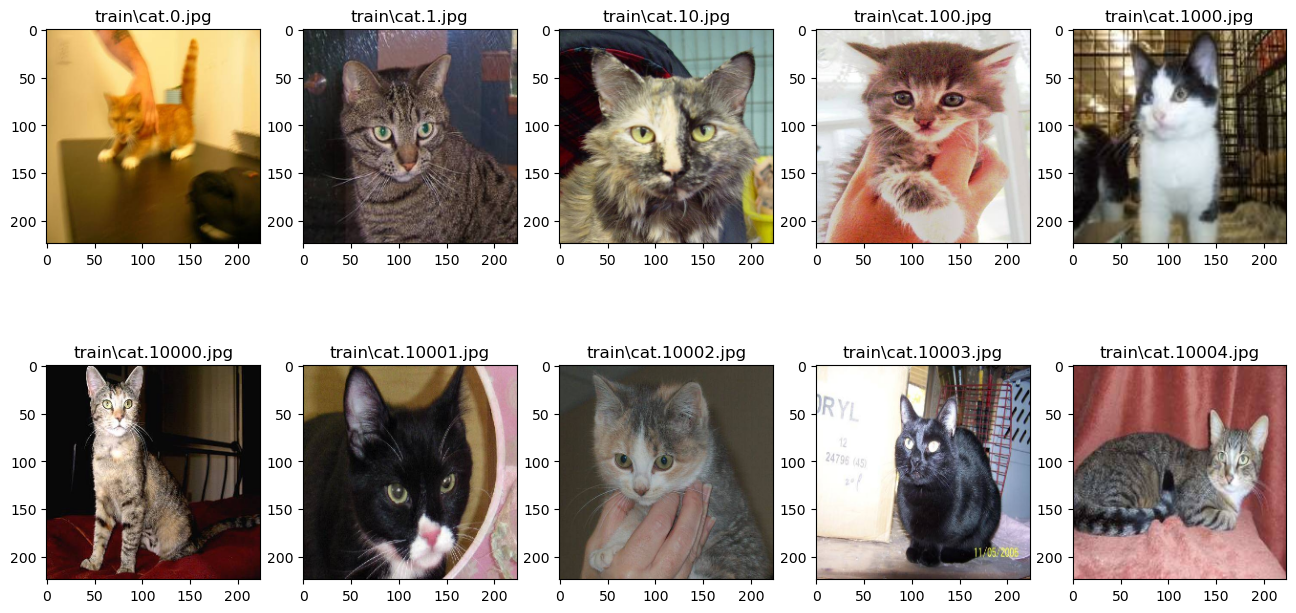

In [40]:
# визуализация примеров для обучения
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [150]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [151]:
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [159]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [160]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [161]:
# уменьшение скорости обучения при замедлении улучшения метрики
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              patience=3,
                              factor=0.5,
                              min_lr=0.0000001)

# остановка обучения при прекращении улучшения метрики
early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=5)

# сохранение промужеточных данных по модели/весов
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              'model_VGG16_tuning_catsdogs.keras',
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True,
                              mode='min')

In [162]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

In [163]:
hist = model.fit(train_data,
                 batch_size=128,
                 steps_per_epoch=20,
                 epochs=30,
                 validation_data=validation_data,
                 callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.7339 - accuracy: 0.6187
Epoch 1: val_loss improved from inf to 0.87255, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 73s 4s/step - loss: 0.7339 - accuracy: 0.6187 - val_loss: 0.8726 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8141
Epoch 2: val_loss improved from 0.87255 to 0.49732, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 75s 4s/step - loss: 0.4459 - accuracy: 0.8141 - val_loss: 0.4973 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8422
Epoch 3: val_loss improved from 0.49732 to 0.24849, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 67s 3s/step - loss: 0.4106 - accuracy: 0.8422 - val_loss: 0.2485 - val_accuracy: 0.

Epoch 26/30
20/20 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9281
Epoch 26: val_loss improved from 0.07993 to 0.07613, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 68s 3s/step - loss: 0.2342 - accuracy: 0.9281 - val_loss: 0.0761 - val_accuracy: 1.0000 - lr: 5.0000e-05
Epoch 27/30
20/20 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9266
Epoch 27: val_loss improved from 0.07613 to 0.07285, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 76s 4s/step - loss: 0.2369 - accuracy: 0.9266 - val_loss: 0.0728 - val_accuracy: 1.0000 - lr: 5.0000e-05
Epoch 28/30
20/20 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9156
Epoch 28: val_loss improved from 0.07285 to 0.07090, saving model to model_VGG16_tuning_catsdogs.keras
20/20 [==============================] - 68s 3s/step - loss: 0.2349 - accuracy: 0.9156 - val_loss: 0.0709 - val_ac

In [ ]:
# model.save('model_VGG16_tuning_catsdogs.keras')

In [164]:
model.load_weights('model_VGG16_tuning_catsdogs.keras')

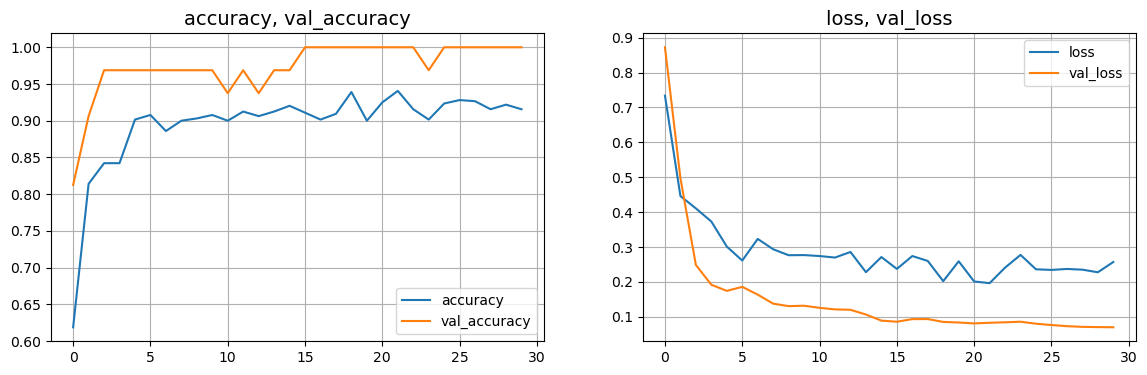

In [165]:
# визуализация динамики обучения модели

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy, val_accuracy'.format(round(hist.history['accuracy'][-1], 3), 
                                                   round(hist.history['val_accuracy'][-1], 3))), fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss, val_loss'.format(round(hist.history['loss'][-1], 3), 
                                           round(hist.history['val_loss'][-1], 3))), fontsize=14)
plt.grid(True)
plt.show()

12500/12500 [==============================] - 1443s 115ms/step


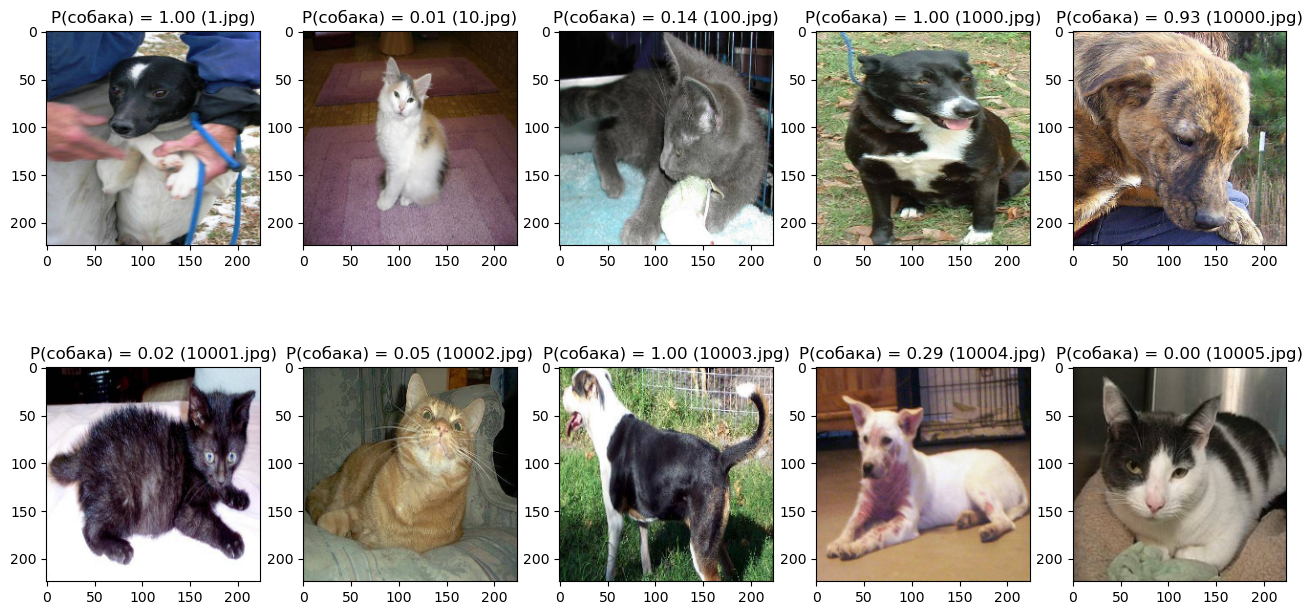

In [166]:
# предсказание на тестовой выборке (с визуализацией первых 10 предсказаний)

test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('P(собака) = %.2f (%s)' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [167]:
# подготовка данных для отправки

with open('submission.csv', 'w') as sub:
    sub.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        sub.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))